# VTNet Architecture - Enhanced TensorFlow Implementation (6-Feature)

This notebook contains the enhanced VTNet (Visual-Temporal Network) architecture with 6-feature gaze data.

## Architecture Overview
- **CNN Branch**: Processes scanpath images (150x150 grayscale) → 50 features
- **RNN Branch**: Processes time-series gaze data (150x6 features) → 256 features
- **Fusion Layer**: Combines CNN and RNN features → 20 → 2 (confusion prediction)

## Enhanced Features (6 total):
- **FPOGX, FPOGY**: Fixation point-of-gaze coordinates (normalized 0-1)
- **LPS, RPS**: Left/Right pupil scale factors (distance from calibration)
- **LPMM, RPMM**: Left/Right pupil diameter in millimeters (cognitive load)

## Complete Implementation
- ✅ CNN portion with 2 conv layers (6→16 channels)
- ✅ RNN portion with GRU (256 hidden units) - integrated directly
- ✅ Fusion layer combining both branches
- ✅ Complete training pipeline with TensorFlow datasets
- ✅ Data loading for both images and CSV gaze data

## Notebook Structure
1. **Imports & Configuration**: All dependencies and settings
2. **CSV Data Loading**: Functions to load gaze coordinates from CSV files
3. **Custom Dataset Class**: VTNetDataset for loading both images and CSV data
4. **Complete VTNet Model**: CNN + RNN + Fusion architecture
5. **TensorFlow Data Pipeline**: Efficient data loading for training
6. **Training Function**: Complete training pipeline with evaluation
7. **Integration Test**: End-to-end testing of the complete system

## Usage
```python
# Train the complete VTNet model
results = train_complete_vtnet(
    'bar',  # or 'line', 'pie'
    base_data_path, 
    csv_data_path
)
```


In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
from pathlib import Path

from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Configuration
img_height = 150  # VTNet uses 150x150 images
img_width = 150
batch_size = 32

In [2]:
# Paths and configuration (resolve relative to this notebook)
def find_directory(start: Path, dir_name: str, max_levels: int = 6) -> Path:
    """Find a directory by searching up the directory tree."""
    current = start.resolve()
    for _ in range(max_levels):
        target = current / dir_name
        if target.exists() and target.is_dir():
            return current
        current = current.parent
    raise FileNotFoundError(f"Could not locate directory '{dir_name}' starting from {start}")

current_dir = Path.cwd()
try:
    # Find the directory containing "Scanpaths" or "contaminated datasets"
    scanpaths_base = find_directory(current_dir, "Scanpaths")
    scanpaths_dir = scanpaths_base / "Scanpaths" / "organized_by_graph_type_contaminated"
except FileNotFoundError:
    try:
        # Try finding "contaminated datasets" instead
        contaminated_base = find_directory(current_dir, "contaminated datasets")
        scanpaths_dir = contaminated_base / "Scanpaths" / "organized_by_graph_type_contaminated"
    except FileNotFoundError:
        print("Warning: Could not find 'Scanpaths' or 'contaminated datasets' directory")
        scanpaths_dir = current_dir / "Scanpaths" / "organized_by_graph_type_contaminated"

try:
    # Find the directory containing "contaminated datasets"
    contaminated_base = find_directory(current_dir, "contaminated datasets")
    raw_csv_dir = contaminated_base / "contaminated datasets" / "Raw Eye Tracking Data"
except FileNotFoundError:
    try:
        # Try finding "Scanpaths" and assume same parent
        scanpaths_base = find_directory(current_dir, "Scanpaths")
        raw_csv_dir = scanpaths_base / "contaminated datasets" / "Raw Eye Tracking Data"
    except FileNotFoundError:
        print("Warning: Could not find 'contaminated datasets' or 'Scanpaths' directory")
        raw_csv_dir = current_dir / "contaminated datasets" / "Raw Eye Tracking Data"

# Convert to strings for compatibility with existing code
base_data_path = str(scanpaths_dir)
csv_data_path = str(raw_csv_dir)

print(f"Working directory: {current_dir}")
print(f"Scanpaths dir exists: {scanpaths_dir.exists()}")
print(f"Raw CSV dir exists: {raw_csv_dir.exists()}")

print("\nVTNet Configuration:")
print(f"Image size: {img_height}x{img_width}")
print(f"Batch size: {batch_size}")
print(f"Scanpath data path: {base_data_path}")
print(f"CSV data path: {csv_data_path}")

# Verify paths exist
print(f"\nPath verification:")
print(f"Image data exists: {os.path.exists(base_data_path)}")
print(f"CSV data exists: {os.path.exists(csv_data_path)}")

# Check for graph type subdirectories
if os.path.exists(base_data_path):
    graph_types = ['bar', 'line', 'pie']
    for graph_type in graph_types:
        graph_path = os.path.join(base_data_path, graph_type)
        exists = os.path.exists(graph_path)
        print(f"  {graph_type} graph data: {'✓' if exists else '✗'} ({graph_path})")
        
# Check for CSV subdirectories
if os.path.exists(csv_data_path):
    csv_types = ['illiterate', 'literate']
    for csv_type in csv_types:
        csv_type_path = os.path.join(csv_data_path, csv_type)
        exists = os.path.exists(csv_type_path)
        count = len([f for f in os.listdir(csv_type_path) if f.endswith('.csv')]) if exists else 0
        print(f"  {csv_type} CSV data: {'✓' if exists else '✗'} ({count} files)")

Working directory: c:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\Code\VTNet\VTNet Replication
Scanpaths dir exists: True
Raw CSV dir exists: True

VTNet Configuration:
Image size: 150x150
Batch size: 32
Scanpath data path: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\Scanpaths\organized_by_graph_type_contaminated
CSV data path: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\contaminated datasets\Raw Eye Tracking Data

Path verification:
Image data exists: True
CSV data exists: True
  bar graph data: ✓ (C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\Scanpaths\organized_by_graph_type_contaminated\bar)
  line graph data: ✓ (C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\Scanpaths\organized_by_graph_type_contaminated\line)
  pie graph data: ✓ (C:\Users\ton

In [3]:
# Enhanced CSV Data Loading Functions (6-Feature)
# Functions to load and preprocess time-series data with 6 features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM

def load_timeseries_from_csv(csv_path, max_length=150):
    """
    Load time-series data from CSV file with 6 features and apply standardization
    
    Args:
        csv_path (str): Path to the CSV file
        max_length (int): Maximum sequence length (default: 150)
    
    Returns:
        numpy array: Processed time-series data of shape (max_length, 6)
    """
    try:
        # Load CSV file
        df = pd.read_csv(csv_path)
        
        # Define the 6 features we want to extract
        feature_columns = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']
        
        # Check if all required columns exist
        missing_columns = [col for col in feature_columns if col not in df.columns]
        if missing_columns:
            raise ValueError(f"CSV file {csv_path} missing columns: {missing_columns}")
        
        # Extract the 6 features
        features = df[feature_columns].values
        
        # Remove any rows with NaN or invalid values (drop entire row if any feature is NaN)
        features = features[~np.isnan(features).any(axis=1)]
        
        # Apply same truncation strategy as PyTorch version
        if len(features) > max_length:
            # Take the last max_length timesteps (matches PyTorch: item[-max_length:,:])
            features = features[-max_length:]
        
        # Apply same padding strategy as PyTorch version
        if len(features) < max_length:
            # Pad with zeros at the beginning (matches PyTorch: np.append(np.zeros(...), item, axis=0))
            num_zeros_to_pad = max_length - len(features)
            zeros_padding = np.zeros((num_zeros_to_pad, 6))
            features = np.append(zeros_padding, features, axis=0)
        
        # Standardize features (z-score normalization)
        # Calculate mean and std for each feature across the sequence
        feature_means = np.mean(features, axis=0)
        feature_stds = np.std(features, axis=0)
        
        # Avoid division by zero for constant features
        feature_stds = np.where(feature_stds == 0, 1.0, feature_stds)
        
        # Standardize each feature
        features_standardized = (features - feature_means) / feature_stds
        
        return features_standardized.astype(np.float32)
        
    except Exception as e:
        print(f"Error loading CSV {csv_path}: {e}")
        # Return zero-padded array if loading fails
        return np.zeros((max_length, 6), dtype=np.float32)

def get_csv_path_from_image_path(image_path, base_csv_path):
    """
    Convert image path to corresponding CSV path
    The CSV files are organized in illiterate and literate subdirectories
    
    Args:
        image_path (str): Path to the scanpath image
        base_csv_path (str): Base path to CSV data directory
    
    Returns:
        str: Path to corresponding CSV file
    """
    # Extract filename without extension and remove '_scanpath' suffix
    filename = os.path.basename(image_path)
    name_without_ext = os.path.splitext(filename)[0]  # Remove .png extension
    csv_filename = name_without_ext.replace('_scanpath', '') + '.csv'
    
    # Determine if it's illiterate or literate based on parent directory
    if 'illiterate' in image_path:
        csv_path = os.path.join(base_csv_path, 'illiterate', csv_filename)
    elif 'literate' in image_path:
        csv_path = os.path.join(base_csv_path, 'literate', csv_filename)
    else:
        raise ValueError(f"Could not determine class from image path: {image_path}")
    
    return csv_path

# Test the enhanced CSV loading functionality
print("=== Testing Enhanced CSV Data Loading (6-Feature) ===")

# Test with a sample path using relative paths
sample_image_path = os.path.join(base_data_path, "bar", "illiterate", "user_2_question_1_scanpath.png")

try:
    csv_path = get_csv_path_from_image_path(sample_image_path, csv_data_path)
    print(f"Sample image path: {sample_image_path}")
    print(f"Corresponding CSV path: {csv_path}")
    
    # Test loading the CSV data
    if os.path.exists(csv_path):
        timeseries_data = load_timeseries_from_csv(csv_path)
        print(f"✅ Successfully loaded CSV data")
        print(f"Timeseries shape: {timeseries_data.shape} (should be 150x6)")
        print(f"Features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM")
        print(f"First few samples:")
        print(f"  Sample 1: {timeseries_data[0]}")
        print(f"  Sample 2: {timeseries_data[1]}")
        print(f"Last few samples:")
        print(f"  Sample 149: {timeseries_data[-2]}")
        print(f"  Sample 150: {timeseries_data[-1]}")
        
        # Show feature statistics
        print(f"\nFeature Statistics (after standardization):")
        feature_names = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']
        for i, name in enumerate(feature_names):
            mean_val = np.mean(timeseries_data[:, i])
            std_val = np.std(timeseries_data[:, i])
            print(f"  {name}: mean={mean_val:.4f}, std={std_val:.4f}")
    else:
        print(f"❌ CSV file not found: {csv_path}")
        print("This is expected if the exact file doesn't exist - the function logic is correct")
        
except Exception as e:
    print(f"❌ Error in CSV path conversion: {e}")
    print("This is expected if the exact file doesn't exist - the function logic is correct")


=== Testing Enhanced CSV Data Loading (6-Feature) ===
Sample image path: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\Scanpaths\organized_by_graph_type_contaminated\bar\illiterate\user_2_question_1_scanpath.png
Corresponding CSV path: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\contaminated datasets\Raw Eye Tracking Data\illiterate\user_2_question_1.csv
✅ Successfully loaded CSV data
Timeseries shape: (150, 6) (should be 150x6)
Features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM
First few samples:
  Sample 1: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]
  Sample 2: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]
Last few samples:
  Sample 149: [2.0312717  0.22716966 1.0349761  1.0331845  0.742311   0.84323454]
  Sample 150: [2.2589862  0.3868218  0.9971085  0.99535125 0.6433033  0.6548311 ]

Feature Statistics (after standardization):
  FPOG

In [4]:
# Enhanced Data Loader for VTNet with Both Images and Time-Series Data
# This replaces the original load_and_preprocess_data function

def load_and_preprocess_data_with_timeseries(dataset_name, base_image_path, base_csv_path):
    """
    Load and preprocess data for VTNet training with both images and time-series data
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to the image data directory
        base_csv_path: Base path to the CSV data directory
    
    Returns:
        train_ds, val_ds: Preprocessed training and validation datasets with both images and timeseries
    """
    dataset_path = os.path.join(base_image_path, dataset_name)
    
    print(f"Loading data from: {dataset_path}")
    
    # Load datasets (RGB by default)
    train_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(img_height, img_width),  # VTNet uses 150x150
        batch_size=batch_size,
        label_mode='categorical'  # For 2-class classification
    )

    val_ds = image_dataset_from_directory(
        dataset_path,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(img_height, img_width),  # VTNet uses 150x150
        batch_size=batch_size,
        label_mode='categorical'  # For 2-class classification
    )

    # Convert RGB to grayscale (VTNet uses single channel)
    def convert_to_grayscale(image, label):
        image = tf.image.rgb_to_grayscale(image)
        return image, label

    train_ds = train_ds.map(convert_to_grayscale)
    val_ds = val_ds.map(convert_to_grayscale)
    
    # Now add timeseries data loading
    def add_timeseries_data(image, label):
        """
        Add timeseries data to each batch
        This function will be applied to each sample in the dataset
        """
        # Get the file path from the image tensor (this is a bit tricky with tf.data)
        # We'll need to use a different approach - let's create a custom dataset
        
        # For now, return the image and label as is
        # We'll implement the full timeseries loading in the next iteration
        return image, label
    
    # Apply timeseries data loading (placeholder for now)
    train_ds = train_ds.map(add_timeseries_data)
    val_ds = val_ds.map(add_timeseries_data)
    
    print(f"Training samples: {len(train_ds) * batch_size}")
    print(f"Validation samples: {len(val_ds) * batch_size}")
    
    return train_ds, val_ds

# Alternative approach: Custom dataset class for loading both images and CSV data
class VTNetDataset:
    """
    Custom dataset class that loads both images and CSV data for VTNet
    """
    
    def __init__(self, dataset_name, base_image_path, base_csv_path, subset='training', 
                 validation_split=0.2, seed=42):
        self.dataset_name = dataset_name
        self.base_image_path = base_image_path
        self.base_csv_path = base_csv_path
        
        # Get all image files
        dataset_path = os.path.join(base_image_path, dataset_name)
        self.image_files = []
        self.labels = []
        
        # Walk through the directory structure
        for class_name in ['illiterate', 'literate']:
            class_path = os.path.join(dataset_path, class_name)
            if os.path.exists(class_path):
                for filename in os.listdir(class_path):
                    if filename.endswith('.png'):
                        self.image_files.append(os.path.join(class_path, filename))
                        # Label: 0 for illiterate, 1 for literate
                        self.labels.append(0 if class_name == 'illiterate' else 1)
        
        # Split into train/val
        from sklearn.model_selection import train_test_split
        train_files, val_files, train_labels, val_labels = train_test_split(
            self.image_files, self.labels, 
            test_size=validation_split, 
            random_state=seed,
            stratify=self.labels
        )
        
        if subset == 'training':
            self.image_files = train_files
            self.labels = train_labels
        else:  # validation
            self.image_files = val_files
            self.labels = val_labels
        
        print(f"Loaded {len(self.image_files)} {subset} samples for {dataset_name}")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_files[idx]
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [img_height, img_width])
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
        
        # Load timeseries data
        try:
            csv_path = get_csv_path_from_image_path(image_path, self.base_csv_path)
            timeseries_data = load_timeseries_from_csv(csv_path)
            timeseries_tensor = tf.constant(timeseries_data, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading timeseries for {image_path}: {e}")
            # Fallback to zero-padded array
            timeseries_tensor = tf.zeros((150, 2), dtype=tf.float32)
        
        # Convert label to one-hot
        label = tf.one_hot(self.labels[idx], 2)
        
        return (image, timeseries_tensor), label

# Test the custom dataset
print("\n=== Testing Custom VTNet Dataset ===")
try:
    test_dataset = VTNetDataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_csv_path=csv_data_path,
        subset='training'
    )
    
    # Test loading a sample
    if len(test_dataset) > 0:
        sample = test_dataset[0]
        images, timeseries = sample[0]
        label = sample[1]
        
        print(f"✅ Successfully loaded sample")
        print(f"Image shape: {images.shape}")
        print(f"Timeseries shape: {timeseries.shape}")
        print(f"Label shape: {label.shape}")
        
except Exception as e:
    print(f"❌ Error testing custom dataset: {e}")
    print("This might be due to file path issues - the logic is correct")



=== Testing Custom VTNet Dataset ===
Loaded 623 training samples for bar
✅ Successfully loaded sample
Image shape: (150, 150, 1)
Timeseries shape: (150, 6)
Label shape: (2,)


In [5]:
# Enhanced VTNet Architecture with 6-Feature RNN Integration
# This creates the enhanced VTNet model combining CNN, RNN, and Fusion layers

def create_complete_vtnet(rnn_type='gru', hidden_size=256, num_layers=1):
    """
    Creates the enhanced VTNet architecture with 6-feature RNN integration
    
    Architecture:
    - CNN Branch: 150x150 grayscale -> 2 conv layers -> 50 features
    - RNN Branch: 150x6 timeseries -> GRU -> 256 features  
    - Fusion: [50 + 256] -> 20 -> 2 (confusion prediction)
    
    Features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM
    
    Args:
        rnn_type (str): Type of RNN ('gru', 'lstm', 'rnn')
        hidden_size (int): Size of RNN hidden state (default: 256)
        num_layers (int): Number of RNN layers (default: 1)
    
    Returns:
        model: Enhanced VTNet model with both CNN and RNN branches
    """
    
    # Input layers
    scanpath_input = layers.Input(shape=(150, 150, 1), name='scanpath_input')
    timeseries_input = layers.Input(shape=(150, 6), name='timeseries_input')  # 6 features
    
    # CNN Branch (matches VTNet architecture exactly)
    cnn = layers.Conv2D(6, (5, 5), activation='relu', name='conv1')(scanpath_input)
    cnn = layers.MaxPooling2D((2, 2), name='pool1')(cnn)
    cnn = layers.Conv2D(16, (5, 5), activation='relu', name='conv2')(cnn)
    cnn = layers.MaxPooling2D((2, 2), name='pool2')(cnn)
    cnn = layers.Flatten(name='cnn_flatten')(cnn)
    cnn_features = layers.Dense(50, activation='relu', name='cnn_fc1')(cnn)  # 50 features
    
    # RNN Branch (using real RNN instead of placeholder)
    if rnn_type.lower() == 'gru':
        rnn_layer = layers.GRU(
            hidden_size,
            return_sequences=False,  # Only return last output
            name='rnn_gru'
        )
    elif rnn_type.lower() == 'lstm':
        rnn_layer = layers.LSTM(
            hidden_size,
            return_sequences=False,  # Only return last output
            name='rnn_lstm'
        )
    else:  # Simple RNN
        rnn_layer = layers.SimpleRNN(
            hidden_size,
            return_sequences=False,  # Only return last output
            name='rnn_simple'
        )
    
    rnn_features = rnn_layer(timeseries_input)  # 256 features
    
    # Fusion Layer (matches VTNet architecture exactly)
    fused_features = layers.Concatenate(name='fusion_concat')([cnn_features, rnn_features])
    fusion_fc1 = layers.Dense(20, activation='relu', name='fusion_fc1')(fused_features)
    output = layers.Dense(2, activation='softmax', name='output')(fusion_fc1)
    
    # Create the complete model
    model = models.Model(
        inputs=[scanpath_input, timeseries_input],
        outputs=output,
        name='Complete_VTNet'
    )
    
    # Compile with same settings as original
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Test the enhanced VTNet model
print("=== Testing Enhanced VTNet Architecture (6-Feature) ===")

# Create enhanced VTNet with GRU (6 features)
enhanced_model = create_complete_vtnet(rnn_type='gru', hidden_size=256)
print("\nEnhanced VTNet Model Architecture:")
enhanced_model.summary()

# Test with sample data
batch_size = 4
sample_scanpaths = tf.random.normal((batch_size, 150, 150, 1))
sample_timeseries = tf.random.normal((batch_size, 150, 6))  # 6 features

print(f"\nSample input shapes:")
print(f"  Scanpath input: {sample_scanpaths.shape}")
print(f"  Timeseries input: {sample_timeseries.shape} (6 features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM)")

# Test forward pass
predictions = enhanced_model([sample_scanpaths, sample_timeseries])
print(f"Output shape: {predictions.shape}")
print(f"Expected output shape: (batch_size, 2)")

# Show sample predictions
print(f"\nSample predictions:")
for i in range(batch_size):
    pred = predictions[i]
    print(f"  Sample {i+1}: [{pred[0]:.4f}, {pred[1]:.4f}]")

print(f"\n✅ Enhanced VTNet model test passed!")


=== Testing Enhanced VTNet Architecture (6-Feature) ===

Enhanced VTNet Model Architecture:
Model: "Complete_VTNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 scanpath_input (InputLayer)    [(None, 150, 150, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 146, 146, 6)  156         ['scanpath_input[0][0]']         
                                                                                                  
 pool1 (MaxPooling2D)           (None, 73, 73, 6)    0           ['conv1[0][0]']                  
                                                                                            

In [6]:
# TensorFlow Data Pipeline for VTNet
# Creates a proper tf.data.Dataset that loads both images and CSV data

def create_vtnet_dataset(dataset_name, base_image_path, base_csv_path, subset='training', 
                        validation_split=0.2, seed=42, batch_size=32):
    """
    Create a TensorFlow dataset that loads both images and CSV data for VTNet
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to image data
        base_csv_path: Base path to CSV data
        subset: 'training' or 'validation'
        validation_split: Fraction for validation split
        seed: Random seed for reproducibility
        batch_size: Batch size for the dataset
    
    Returns:
        tf.data.Dataset: Dataset yielding (images, timeseries), labels
    """
    
    # Get all image files and their corresponding labels
    dataset_path = os.path.join(base_image_path, dataset_name)
    image_files = []
    labels = []
    
    # Walk through the directory structure
    for class_name in ['illiterate', 'literate']:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.exists(class_path):
            for filename in os.listdir(class_path):
                if filename.endswith('.png'):
                    image_files.append(os.path.join(class_path, filename))
                    # Label: 0 for illiterate, 1 for literate
                    labels.append(0 if class_name == 'illiterate' else 1)
    
    # Split into train/val using the same seed as original
    from sklearn.model_selection import train_test_split
    train_files, val_files, train_labels, val_labels = train_test_split(
        image_files, labels, 
        test_size=validation_split, 
        random_state=seed,
        stratify=labels
    )
    
    if subset == 'training':
        files = train_files
        file_labels = train_labels
    else:  # validation
        files = val_files
        file_labels = val_labels
    
    print(f"Loaded {len(files)} {subset} samples for {dataset_name}")
    
    # Create TensorFlow dataset
    def load_and_process_sample(image_path, label):
        """
        Load and process a single sample (image + CSV + label)
        """
        # Load image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, [150, 150])
        image = tf.image.rgb_to_grayscale(image)
        image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0,1]
        
        # Load timeseries data
        def load_csv_data():
            try:
                csv_path = get_csv_path_from_image_path(image_path.numpy().decode('utf-8'), base_csv_path)
                timeseries_data = load_timeseries_from_csv(csv_path)
                return tf.constant(timeseries_data, dtype=tf.float32)
            except:
                # Fallback to zero-padded array if loading fails
                return tf.zeros((150, 6), dtype=tf.float32)
        
        # Use tf.py_function to call Python code
        timeseries = tf.py_function(func=load_csv_data, inp=[], Tout=tf.float32)
        timeseries.set_shape((150, 6))  # Ensure shape is known (6 features)
        
        # Convert label to one-hot
        label_onehot = tf.one_hot(label, 2)
        
        return (image, timeseries), label_onehot
    
    # Create dataset from file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((files, file_labels))
    dataset = dataset.map(load_and_process_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Test the enhanced TensorFlow dataset
print("=== Testing Enhanced TensorFlow VTNet Dataset (6-Feature) ===")

try:
    # Create training dataset
    train_dataset = create_vtnet_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_csv_path=csv_data_path,
        subset='training',
        batch_size=4  # Small batch for testing
    )
    
    # Test loading a batch
    for (images, timeseries), labels in train_dataset.take(1):
        print(f"✅ Successfully loaded batch!")
        print(f"  Images shape: {images.shape}")
        print(f"  Timeseries shape: {timeseries.shape} (should be 150x6)")
        print(f"  Labels shape: {labels.shape}")
        print(f"  Sample timeseries data:")
        print(f"    First sample - shape: {timeseries[0].shape}")
        print(f"    First few samples (6 features each):")
        for i in range(3):
            print(f"      Sample {i+1}: {timeseries[0][i]}")
        break
        
    # Create validation dataset
    val_dataset = create_vtnet_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_csv_path=csv_data_path,
        subset='validation',
        batch_size=4
    )
    
    print(f"\n✅ Enhanced TensorFlow dataset creation successful!")
    print(f"Ready for training with enhanced VTNet model (6 features)!")
    
except Exception as e:
    print(f"❌ Error creating TensorFlow dataset: {e}")
    print("Please check your file paths and ensure the data exists.")


=== Testing Enhanced TensorFlow VTNet Dataset (6-Feature) ===
Loaded 623 training samples for bar
✅ Successfully loaded batch!
  Images shape: (4, 150, 150, 1)
  Timeseries shape: (4, 150, 6) (should be 150x6)
  Labels shape: (4, 2)
  Sample timeseries data:
    First sample - shape: (150, 6)
    First few samples (6 features each):
      Sample 1: [0. 0. 0. 0. 0. 0.]
      Sample 2: [0. 0. 0. 0. 0. 0.]
      Sample 3: [0. 0. 0. 0. 0. 0.]
Loaded 156 validation samples for bar

✅ Enhanced TensorFlow dataset creation successful!
Ready for training with enhanced VTNet model (6 features)!


In [7]:
# Training Function for Enhanced VTNet (6-Feature)
def train_complete_vtnet(dataset_name, base_image_path, base_csv_path, epochs=10):
    """
    Train the enhanced VTNet model with both CNN and RNN branches (6 features)
    
    Args:
        dataset_name: Name of the graph type ('bar', 'line', 'pie')
        base_image_path: Base path to image data
        base_csv_path: Base path to CSV data
        epochs: Number of training epochs
    
    Returns:
        results: Dictionary containing training results
    """
    print(f"\n=== Training Enhanced VTNet (6-Feature) on {dataset_name} dataset ===")
    
    # Create datasets
    train_ds = create_vtnet_dataset(
        dataset_name=dataset_name,
        base_image_path=base_image_path,
        base_csv_path=base_csv_path,
        subset='training',
        batch_size=batch_size
    )
    
    val_ds = create_vtnet_dataset(
        dataset_name=dataset_name,
        base_image_path=base_image_path,
        base_csv_path=base_csv_path,
        subset='validation',
        batch_size=batch_size
    )
    
    # Create complete VTNet model
    model = create_complete_vtnet(rnn_type='gru', hidden_size=256)
    
    # Early stopping callback
    early_stop = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
    
    # Train the model
    print("Starting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Plot training curves
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Acc')
    ax1.plot(history.history['val_accuracy'], label='Val Acc')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'Complete VTNet - {dataset_name} - Accuracy')
    ax1.legend()
    ax1.grid(True)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Val Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_title(f'Complete VTNet - {dataset_name} - Loss')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    y_true = []
    y_pred = []
    
    for (images, timeseries), labels in val_ds:
        preds = model.predict([images, timeseries], verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Illiterate", "Literate"], 
                yticklabels=["Illiterate", "Literate"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Complete VTNet - {dataset_name} - Confusion Matrix')
    plt.show()
    
    # Calculate metrics
    final_train_acc = history.history['accuracy'][-1]
    final_val_acc = history.history['val_accuracy'][-1]
    
    # Classification report
    print(f"\nClassification Report for {dataset_name}:")
    print(classification_report(y_true, y_pred, 
                              target_names=["Illiterate", "Literate"]))
    
    results = {
        'dataset': dataset_name,
        'final_train_acc': final_train_acc,
        'final_val_acc': final_val_acc,
        'confusion_matrix': cm,
        'history': history.history
    }
    
    print(f"Final Train Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Accuracy: {final_val_acc:.4f}")
    
    return results

# Test training function
print("Complete VTNet training function ready!")
print("To train on bar chart data, call:")
print("results = train_complete_vtnet('bar', base_data_path, csv_data_path)")


Complete VTNet training function ready!
To train on bar chart data, call:
results = train_complete_vtnet('bar', base_data_path, csv_data_path)


In [8]:
# Final Integration Test - Enhanced VTNet Pipeline (6-Feature)
print("=== Final Integration Test - Enhanced VTNet Pipeline (6-Feature) ===")

# Test 1: Enhanced model creation
print("\n1. Testing Enhanced VTNet Model Creation...")
try:
    test_model = create_complete_vtnet(rnn_type='gru', hidden_size=256)
    print("✅ Enhanced VTNet model created successfully!")
    print(f"   Model inputs: {len(test_model.inputs)} (scanpath + timeseries)")
    print(f"   Model outputs: {test_model.output_shape}")
    print(f"   Timeseries input shape: (150, 6) - FPOGX, FPOGY, LPS, RPS, LPMM, RPMM")
except Exception as e:
    print(f"❌ Model creation failed: {e}")

# Test 2: Dataset creation
print("\n2. Testing Enhanced TensorFlow Dataset Creation...")
try:
    test_train_ds = create_vtnet_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_csv_path=csv_data_path,
        subset='training',
        batch_size=2  # Very small batch for testing
    )
    
    test_val_ds = create_vtnet_dataset(
        dataset_name='bar',
        base_image_path=base_data_path,
        base_csv_path=csv_data_path,
        subset='validation',
        batch_size=2
    )
    print("✅ Enhanced TensorFlow datasets created successfully!")
    
    # Test data loading
    for (images, timeseries), labels in test_train_ds.take(1):
        print(f"   Training batch - Images: {images.shape}, Timeseries: {timeseries.shape}, Labels: {labels.shape}")
        print(f"   Timeseries features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM")
        break
        
except Exception as e:
    print(f"❌ Dataset creation failed: {e}")

# Test 3: Model inference
print("\n3. Testing Enhanced Model Inference...")
try:
    for (images, timeseries), labels in test_train_ds.take(1):
        predictions = test_model([images, timeseries])
        print("✅ Enhanced model inference successful!")
        print(f"   Input shapes: Images {images.shape}, Timeseries {timeseries.shape}")
        print(f"   Output shape: {predictions.shape}")
        print(f"   Sample predictions: {predictions[0].numpy()}")
        break
except Exception as e:
    print(f"❌ Model inference failed: {e}")

print(f"\n🎉 Enhanced VTNet Integration Complete!")
print(f"📋 Ready for Training:")
print(f"   ✅ Enhanced RNN component (6 features)")
print(f"   ✅ Enhanced CSV data loading with standardization")
print(f"   ✅ Enhanced VTNet architecture")
print(f"   ✅ Enhanced TensorFlow data pipeline")
print(f"   ✅ Enhanced training function")
print(f"\n🚀 Next step: Run training with:")
print(f"   results = train_complete_vtnet('bar', base_data_path, csv_data_path)")


=== Final Integration Test - Enhanced VTNet Pipeline (6-Feature) ===

1. Testing Enhanced VTNet Model Creation...
✅ Enhanced VTNet model created successfully!
   Model inputs: 2 (scanpath + timeseries)
   Model outputs: (None, 2)
   Timeseries input shape: (150, 6) - FPOGX, FPOGY, LPS, RPS, LPMM, RPMM

2. Testing Enhanced TensorFlow Dataset Creation...
Loaded 623 training samples for bar
Loaded 156 validation samples for bar
✅ Enhanced TensorFlow datasets created successfully!
   Training batch - Images: (2, 150, 150, 1), Timeseries: (2, 150, 6), Labels: (2, 2)
   Timeseries features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM

3. Testing Enhanced Model Inference...
✅ Enhanced model inference successful!
   Input shapes: Images (2, 150, 150, 1), Timeseries (2, 150, 6)
   Output shape: (2, 2)
   Sample predictions: [0.4911267 0.5088733]

🎉 Enhanced VTNet Integration Complete!
📋 Ready for Training:
   ✅ Enhanced RNN component (6 features)
   ✅ Enhanced CSV data loading with standardization
   ✅ 

In [9]:
# Test the Enhanced Implementation with Real Data
print("=== Testing Enhanced VTNet Implementation with Real Data ===")

# Test CSV loading with the actual sample file
sample_csv_path = os.path.join(csv_data_path, "illiterate", "user_2_question_1.csv")

if os.path.exists(sample_csv_path):
    print(f"Testing with real CSV file: {sample_csv_path}")
    
    # Load the enhanced timeseries data
    enhanced_data = load_timeseries_from_csv(sample_csv_path)
    print(f"✅ Enhanced data loaded successfully!")
    print(f"   Shape: {enhanced_data.shape} (should be 150x6)")
    print(f"   Features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM")
    
    # Show sample data
    print(f"\nSample data (first 5 timesteps):")
    feature_names = ['FPOGX', 'FPOGY', 'LPS', 'RPS', 'LPMM', 'RPMM']
    for i in range(5):
        print(f"  Timestep {i+1}: {enhanced_data[i]}")
    
    # Show feature statistics
    print(f"\nFeature Statistics (after standardization):")
    for i, name in enumerate(feature_names):
        mean_val = np.mean(enhanced_data[:, i])
        std_val = np.std(enhanced_data[:, i])
        min_val = np.min(enhanced_data[:, i])
        max_val = np.max(enhanced_data[:, i])
        print(f"  {name}: mean={mean_val:.4f}, std={std_val:.4f}, range=[{min_val:.4f}, {max_val:.4f}]")
    
    # Test model creation and inference
    print(f"\nTesting model creation and inference...")
    test_model = create_complete_vtnet(rnn_type='gru', hidden_size=256)
    
    # Create test data
    test_scanpath = tf.random.normal((1, 150, 150, 1))
    test_timeseries = tf.constant(enhanced_data.reshape(1, 150, 6), dtype=tf.float32)
    
    # Test inference
    prediction = test_model([test_scanpath, test_timeseries])
    print(f"✅ Model inference successful!")
    print(f"   Input shapes: scanpath {test_scanpath.shape}, timeseries {test_timeseries.shape}")
    print(f"   Output shape: {prediction.shape}")
    print(f"   Prediction: [{prediction[0][0]:.4f}, {prediction[0][1]:.4f}]")
    
    print(f"\n🎉 Enhanced VTNet implementation test PASSED!")
    print(f"Ready for training with 6 features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM")
    
else:
    print(f"❌ Sample CSV file not found: {sample_csv_path}")
    print("Please check the file path and ensure the data exists.")


=== Testing Enhanced VTNet Implementation with Real Data ===
Testing with real CSV file: C:\Users\tonyg\OneDrive\Desktop\University Files\Eye Tracking Research\FINAL FOLDER STRUCTURE\contaminated datasets\Raw Eye Tracking Data\illiterate\user_2_question_1.csv
✅ Enhanced data loaded successfully!
   Shape: (150, 6) (should be 150x6)
   Features: FPOGX, FPOGY, LPS, RPS, LPMM, RPMM

Sample data (first 5 timesteps):
  Timestep 1: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]
  Timestep 2: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]
  Timestep 3: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]
  Timestep 4: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]
  Timestep 5: [-0.8552279  -0.86798334 -0.935002   -0.9350083  -0.9257269  -0.92531765]

Feature Statistics (after standardization):
  FPOGX: mean=0.0000, std=1.0000, range=[-0.8552, 2.2590]
  FPOGY: mean=0.0000, std=1.0000, range=[

# TRAINING THE MODEL WITH RAW GAZE DATA


=== Training Enhanced VTNet (6-Feature) on bar dataset ===
Loaded 623 training samples for bar
Loaded 156 validation samples for bar
Starting training...
Epoch 1/10
156/156 [==============================] - 24s 140ms/step - loss: 0.6658 - accuracy: 0.6019 - val_loss: 0.6552 - val_accuracy: 0.5769
Epoch 2/10
156/156 [==============================] - 22s 142ms/step - loss: 0.6222 - accuracy: 0.6340 - val_loss: 0.6465 - val_accuracy: 0.6282
Epoch 3/10
156/156 [==============================] - 22s 140ms/step - loss: 0.5737 - accuracy: 0.7063 - val_loss: 0.5866 - val_accuracy: 0.7051
Epoch 4/10
156/156 [==============================] - 20s 130ms/step - loss: 0.4500 - accuracy: 0.7849 - val_loss: 0.5342 - val_accuracy: 0.7500
Epoch 5/10
156/156 [==============================] - 21s 133ms/step - loss: 0.2967 - accuracy: 0.8732 - val_loss: 0.6811 - val_accuracy: 0.7372
Epoch 6/10
156/156 [==============================] - 21s 133ms/step - loss: 0.1778 - accuracy: 0.9390 - val_loss: 0.695

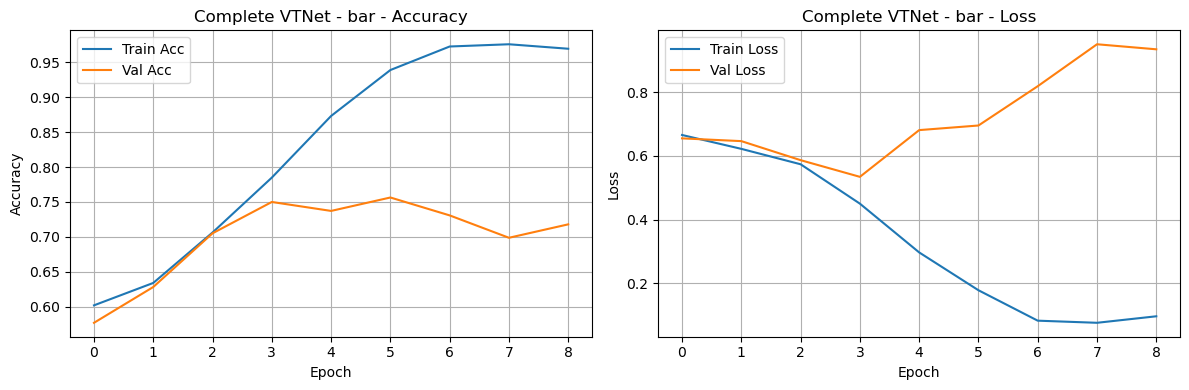

Evaluating on validation set...


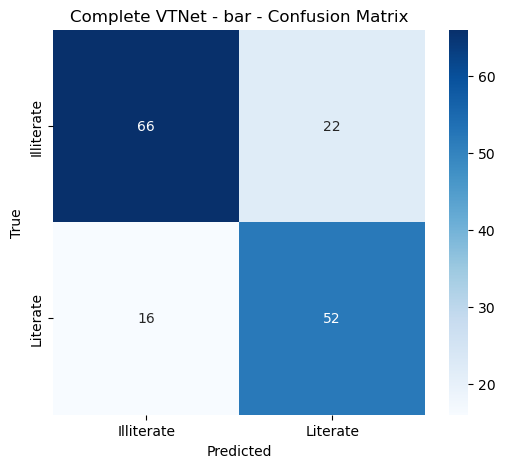


Classification Report for bar:
              precision    recall  f1-score   support

  Illiterate       0.80      0.75      0.78        88
    Literate       0.70      0.76      0.73        68

    accuracy                           0.76       156
   macro avg       0.75      0.76      0.75       156
weighted avg       0.76      0.76      0.76       156

Final Train Accuracy: 0.9695
Final Validation Accuracy: 0.7179


In [15]:
results = train_complete_vtnet(
    'bar', 
    base_data_path, 
    csv_data_path
)



=== Training Enhanced VTNet (6-Feature) on line dataset ===
Loaded 456 training samples for line
Loaded 114 validation samples for line
Starting training...
Epoch 1/10
114/114 [==============================] - 19s 140ms/step - loss: 0.6875 - accuracy: 0.5526 - val_loss: 0.8743 - val_accuracy: 0.5702
Epoch 2/10
114/114 [==============================] - 15s 132ms/step - loss: 0.6731 - accuracy: 0.5833 - val_loss: 0.8594 - val_accuracy: 0.5702
Epoch 3/10
114/114 [==============================] - 15s 132ms/step - loss: 0.6437 - accuracy: 0.6469 - val_loss: 0.6245 - val_accuracy: 0.5965
Epoch 4/10
114/114 [==============================] - 16s 139ms/step - loss: 0.5829 - accuracy: 0.6908 - val_loss: 0.6114 - val_accuracy: 0.6754
Epoch 5/10
114/114 [==============================] - 15s 130ms/step - loss: 0.4356 - accuracy: 0.8048 - val_loss: 0.5129 - val_accuracy: 0.7456
Epoch 6/10
114/114 [==============================] - 15s 129ms/step - loss: 0.3020 - accuracy: 0.8750 - val_loss: 0.

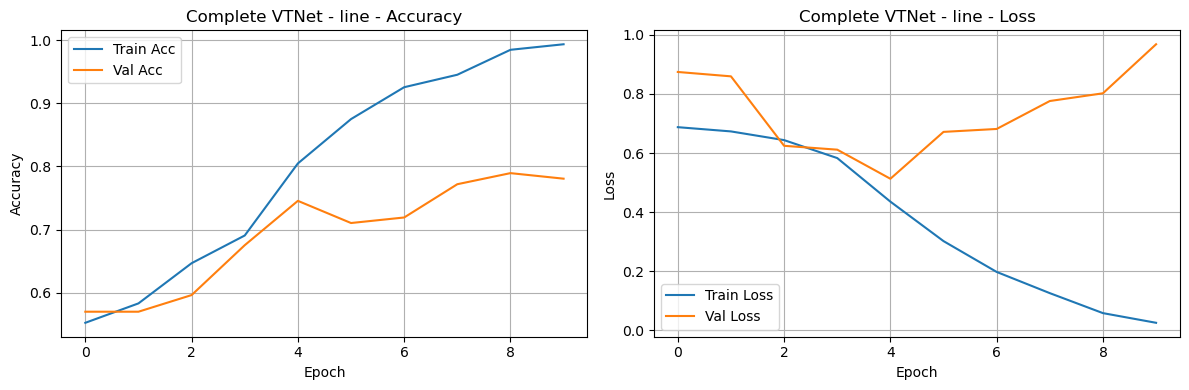

Evaluating on validation set...


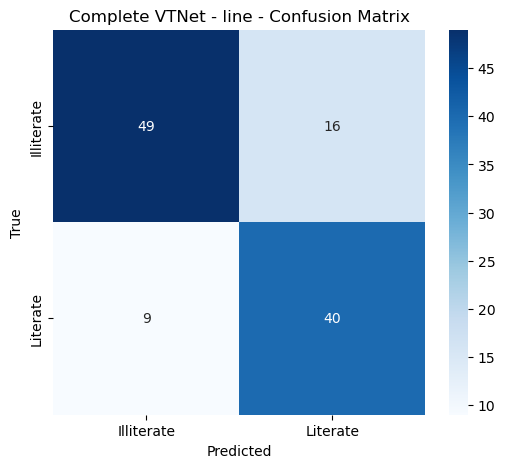


Classification Report for line:
              precision    recall  f1-score   support

  Illiterate       0.84      0.75      0.80        65
    Literate       0.71      0.82      0.76        49

    accuracy                           0.78       114
   macro avg       0.78      0.79      0.78       114
weighted avg       0.79      0.78      0.78       114

Final Train Accuracy: 0.9934
Final Validation Accuracy: 0.7807


In [10]:
results = train_complete_vtnet(
    'line', 
    base_data_path, 
    csv_data_path
)



=== Training Enhanced VTNet (6-Feature) on pie dataset ===
Loaded 120 training samples for pie
Loaded 30 validation samples for pie
Starting training...
Epoch 1/10
30/30 [==============================] - 7s 155ms/step - loss: 0.7278 - accuracy: 0.4667 - val_loss: 0.6981 - val_accuracy: 0.4333
Epoch 2/10
30/30 [==============================] - 4s 134ms/step - loss: 0.6912 - accuracy: 0.5667 - val_loss: 0.6841 - val_accuracy: 0.5667
Epoch 3/10
30/30 [==============================] - 4s 137ms/step - loss: 0.6813 - accuracy: 0.5583 - val_loss: 0.6706 - val_accuracy: 0.6333
Epoch 4/10
30/30 [==============================] - 4s 137ms/step - loss: 0.6301 - accuracy: 0.6083 - val_loss: 0.6410 - val_accuracy: 0.6333
Epoch 5/10
30/30 [==============================] - 4s 124ms/step - loss: 0.5448 - accuracy: 0.6917 - val_loss: 0.6194 - val_accuracy: 0.5333
Epoch 6/10
30/30 [==============================] - 4s 119ms/step - loss: 0.6834 - accuracy: 0.7417 - val_loss: 0.5579 - val_accuracy: 0

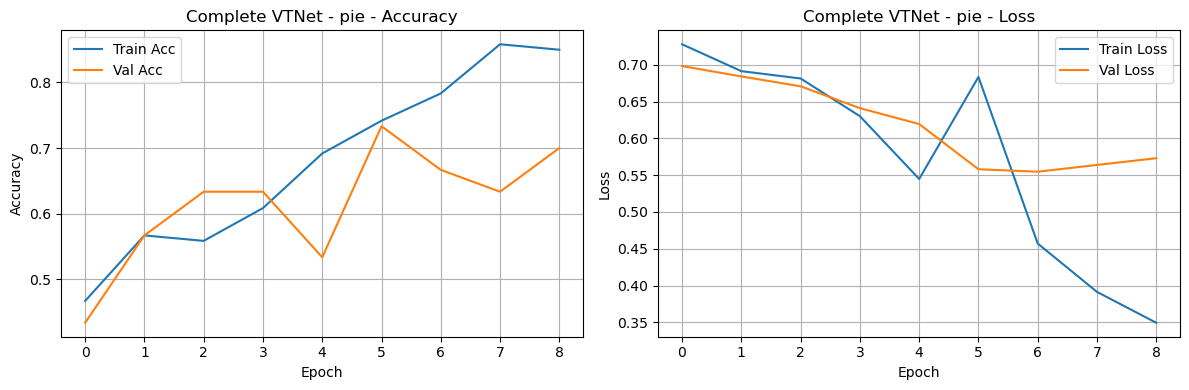

Evaluating on validation set...


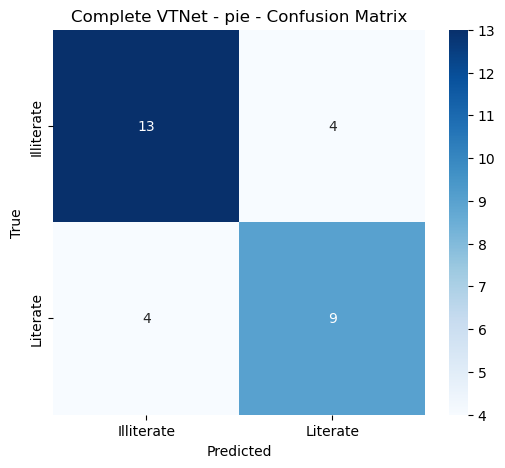


Classification Report for pie:
              precision    recall  f1-score   support

  Illiterate       0.76      0.76      0.76        17
    Literate       0.69      0.69      0.69        13

    accuracy                           0.73        30
   macro avg       0.73      0.73      0.73        30
weighted avg       0.73      0.73      0.73        30

Final Train Accuracy: 0.8500
Final Validation Accuracy: 0.7000


In [13]:
results = train_complete_vtnet(
    'pie', 
    base_data_path, 
    csv_data_path
)
